# Preprocesamiento de dataset SAMM

El dataset **SAMM (Spontaneous Micro-expression Corpus)** está compuesto por **secuencias de video en alta resolución** que capturan expresiones faciales espontáneas, con un enfoque particular en **microexpresiones**, es decir, cambios sutiles y breves en el rostro que reflejan emociones reprimidas.

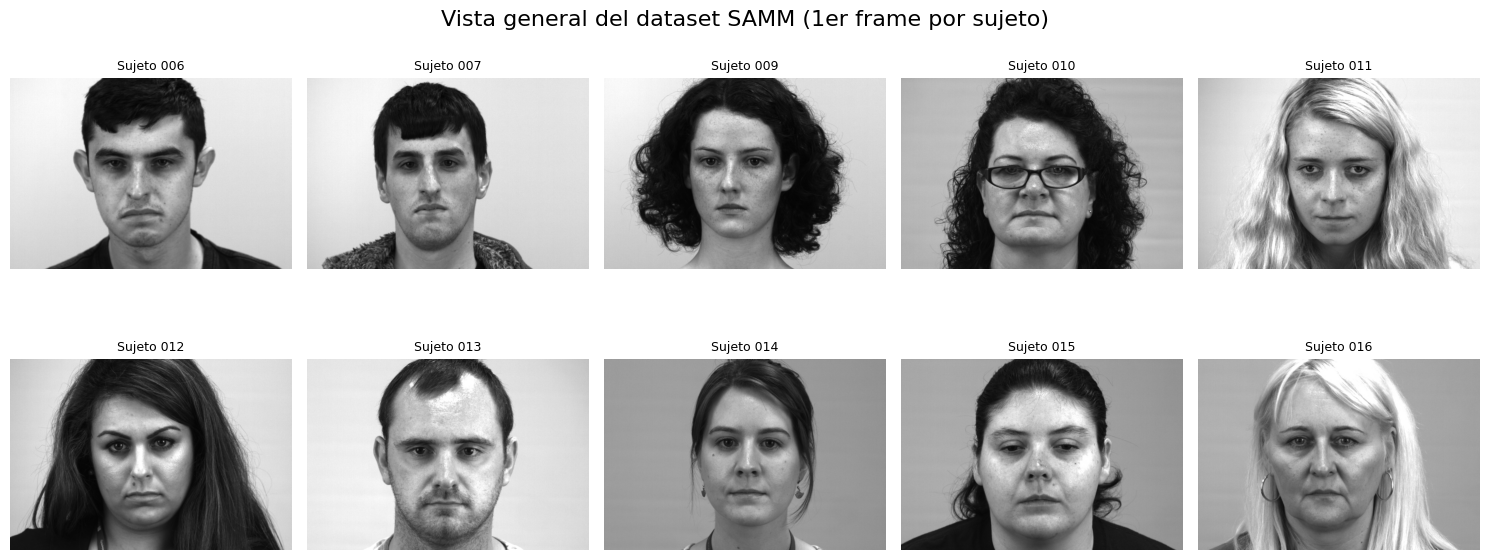

In [3]:
from notebook_utils import presentar_dataset_samm
import matplotlib.pyplot as plt

imagenes, nombres = presentar_dataset_samm('../datasets/SAMM2/SAMM')

## ¿Por qué necesitamos recortes faciales precisos?

Para nuestro propósito —el análisis de **microexpresiones**— nos enfocamos únicamente en la región del **rostro**, ya que es allí donde ocurren los cambios sutiles que buscamos detectar. El resto de la imagen (fondo, ropa, cuerpo) no aporta información útil y puede introducir ruido innecesario en el análisis.

**⚠️ El problema: Variabilidad entre frames**

Aunque el rostro se mantiene relativamente estático en una secuencia, los detectores faciales como `mtcnn.detect()` (de **FaceNet**) o incluso herramientas especializadas como **OpenFace** presentan una **variabilidad ligera pero significativa** en los *bounding boxes* que generan entre cuadros consecutivos.

Esta variabilidad ocurre incluso cuando no hay movimiento facial, y se debe a:
- Microvariaciones en iluminación, enfoque o postura.
- Ajustes internos del modelo (por ejemplo, *padding*, escalado, normalización).
- Precisión subpixel del detector.

⚠️ **Consecuencia:**
Estas diferencias causan que los recortes no estén perfectamente alineados entre frames. Como resultado, al aplicar técnicas como el *optical flow*, se introducen **falsos desplazamientos** que pueden ser interpretados erróneamente como microexpresiones.

> Este comportamiento fue observado tanto al usar `MTCNN` como con **OpenFace**, confirmando que el problema es común a múltiples pipelines de detección facial.

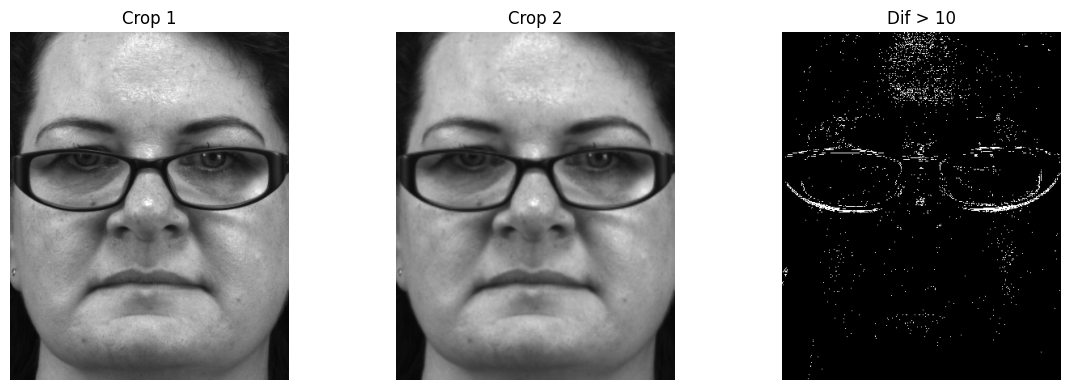

In [5]:
from facenet_pytorch import MTCNN
from notebook_utils import mostrar_diferencia_recortes

# Inicializar modelo
mtcnn = MTCNN(image_size=224, margin=20, keep_all=False, post_process=False)

frame1 = "../datasets/SAMM2/SAMM/010/010_2_1/010_0192.jpg"
frame2 = "../datasets/SAMM2/SAMM/010/010_2_1/010_0193.jpg"

mostrar_diferencia_recortes(mtcnn, frame1, frame2)

> - Aunque el rostro no cambia entre frames, los recortes obtenidos con `MTCNN` muestran ligeras variaciones.  
> - La imagen de la derecha evidencia estas diferencias a través de una máscara binaria (>10), donde se aprecian **bordes espurios** en zonas como las gafas, el mentón y el contorno facial.  
> - Esto ocurre debido a **pequeñas diferencias en la posición, alineación y escala** del recorte facial entre cuadros consecutivos, a pesar de que el contenido visual sea prácticamente idéntico.  
> - Estas inconsistencias introducen **ruido artificial** que puede afectar el análisis posterior con *optical flow*, haciendo que se detecten movimientos donde no los hay.

### Solución: Recorte facial estable mediante *template matching*

Para reducir el ruido causado por los detectores faciales (como MTCNN u OpenFace), que generan ligeras variaciones de recorte entre frames consecutivos, implementamos el siguiente procedimiento:

- Se detecta el rostro **solo en el primer frame** de la secuencia.
- Ese recorte se usa como **plantilla (template)**.
- Luego se aplica **template matching** en los frames siguientes para mantener la misma región facial en todos los cuadros.

Esto permite mantener una **posición y escala constantes** del rostro, evitando que el *optical flow* detecte falsos desplazamientos causados por errores de alineación.

**Referencia principal:**

- [**Consistent Optical Flow Maps for Full and Micro Facial Expression Recognition**](https://www.frontiersin.org/articles/10.3389/fpsyg.2017.01128/full)  
  _Benjamin Allaert, Ioan Marius Bilasco & Chabane Djeraba (2017)_  

> **Otras referencias relacionadas:**
> 
> - [**Normalized Cross-Correlation Based Template Matching for Face Detection**](https://ieeexplore.ieee.org/document/9287523)  
  _Payal Bose & Samir Bandyopadhyay (2020)_
> - [**Template Matching Techniques in Computer Vision: Theory and Practice**](https://www.sciencedirect.com/science/article/abs/pii/S1077314209000581)  
  _Roberto Brunelli (2009)_


In [6]:
def crop_with_template(img, template, prev_box, margin=40, output_size=(224, 224)):
    x1, y1, x2, y2 = prev_box
    h, w = img.shape[:2]
    sx1 = max(0, x1 - margin)
    sy1 = max(0, y1 - margin)
    sx2 = min(w, x2 + margin)
    sy2 = min(h, y2 + margin)
    search_region = img[sy1:sy2, sx1:sx2]

    if search_region.shape[0] < template.shape[0] or search_region.shape[1] < template.shape[1]:
        return None

    res = cv2.matchTemplate(search_region, template, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(res)
    top_left = (sx1 + max_loc[0], sy1 + max_loc[1])
    bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
    crop = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    return cv2.resize(crop, output_size)

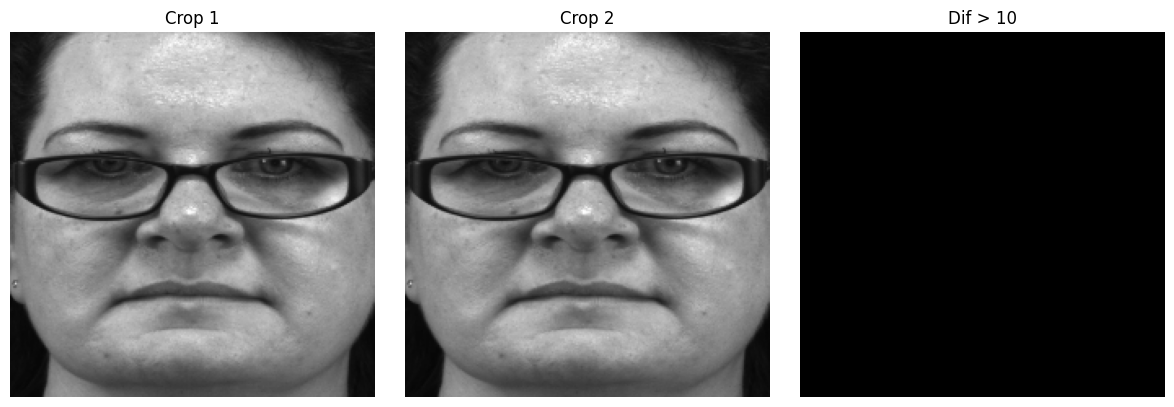

In [7]:
from PIL import Image
import cv2

img1 = cv2.imread("../datasets/SAMM2/SAMM/010/010_2_1/010_0192.jpg")
img2 = cv2.imread("../datasets/SAMM2/SAMM/010/010_2_1/010_0193.jpg")

# Detectar rostro en frame1 con MTCNN
img1_pil = Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
box1, _ = mtcnn.detect(img1_pil)

x1, y1, x2, y2 = map(int, box1[0])
face1_crop = img1[y1:y2, x1:x2]
face1_resized = cv2.resize(face1_crop, (224, 224))

# Usar el recorte del frame1 como template para el frame2
face2_aligned = crop_with_template(img2, face1_crop, (x1, y1, x2, y2))

mostrar_diferencia_recortes(mtcnn, face1_resized, face2_aligned)

> - Luego de aplicar **template matching** para alinear los recortes faciales, la máscara de diferencias (>10) muestra una imagen completamente negra.  
> - Esto indica que no existen variaciones significativas entre ambos frames, confirmando que la región del rostro se mantiene perfectamente alineada en posición, escala y orientación.  
> - A diferencia del recorte con `MTCNN` frame a frame, esta estrategia evita bordes espurios y elimina el ruido estructural, permitiendo que el *optical flow* se concentre únicamente en los cambios reales de expresión.

### Normalización del dataset SAMM mediante *template matching*

Para garantizar que los análisis posteriores (como *optical flow*) se enfoquen únicamente en las microexpresiones y no en errores de recorte, normalizaremos todo el dataset **SAMM** utilizando *template matching*.

Procesaremos cada sujeto y cada secuencia del dataset, detectando el rostro únicamente en el **primer frame** de cada secuencia.  
Ese recorte servirá como **plantilla de referencia** para alinear los rostros en los siguientes frames de la misma secuencia.

- Esto asegura que todos los recortes mantengan una **posición, escala y orientación coherentes** a lo largo del tiempo, reduciendo el ruido estructural y facilitando la detección de cambios sutiles.

> El resultado se almacenará como un nuevo dataset llamado `SAMM_Normalized`, con la misma estructura que el original pero con rostros ya alineados.

In [8]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

from preprocess_dataset import process_dataset

input_base  = '../datasets/SAMM2/SAMM'
output_base = '../datasets/SAMM2/SAMM_Normalized_TM'

# Llama al procesamiento
process_dataset(input_base, output_base, use_gpu=False)

Clip 037_4_1: 100%|██████████| 90/90 [00:01<00:00, 58.65it/s]


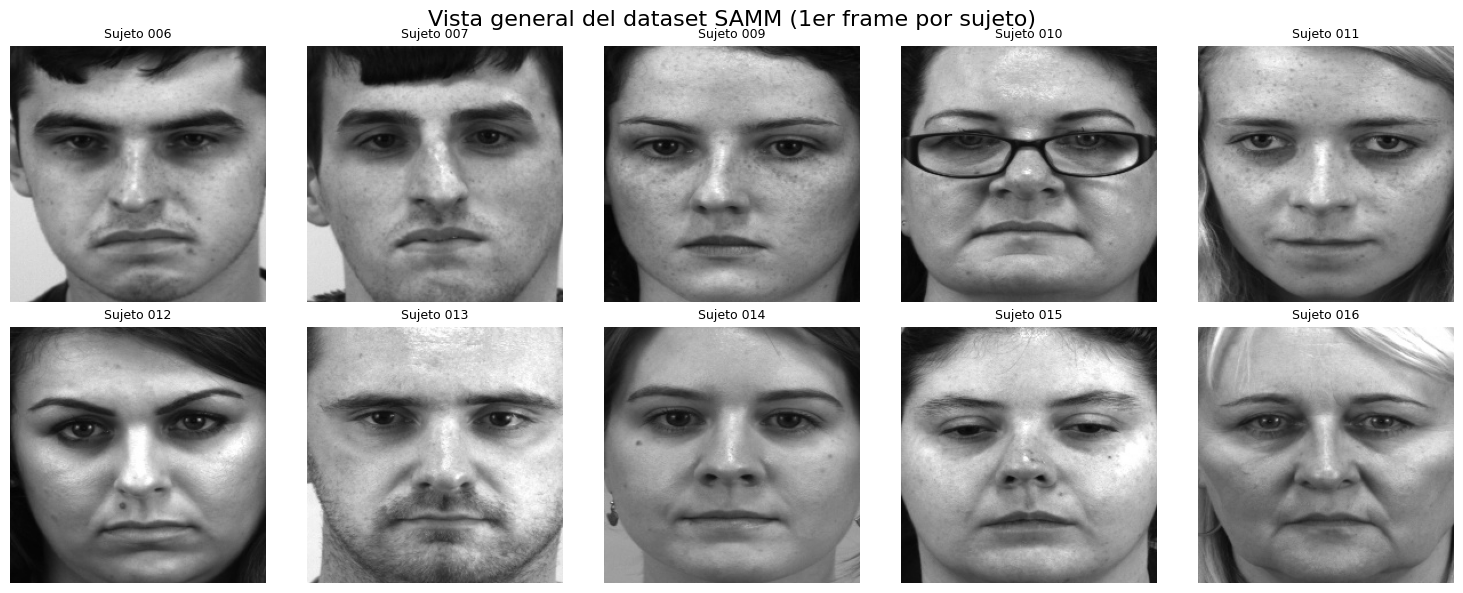

In [9]:
# Presentar el dataset SAMM Normalized_TM
imagenes, nombres = presentar_dataset_samm('../datasets/SAMM2/SAMM_Normalized_TM')

Una vez aplicado el proceso de normalización mediante *template matching*, se espera que todos los frames de una secuencia mantengan una alineación coherente con respecto al rostro de referencia (usualmente el *apex*). Los recortes obtenidos preservan una posición, escala y orientación consistentes del rostro.  

### Optical Flow como Representación del Movimiento Facial

El siguiente paso consiste en transformar las secuencias de imágenes en representaciones visuales del **movimiento facial entre frames**.  
Para ello utilizamos una técnica clásica de visión por computadora: el **Optical Flow**, que estima el desplazamiento aparente de los píxeles entre dos imágenes sucesivas.

#### ¿Qué representa el Optical Flow?

El flujo óptico genera un **campo denso de vectores**, donde cada vector describe el movimiento de un píxel del primer frame hacia el segundo.  
Este campo se puede codificar como una imagen RGB, utilizando el espacio de color **HSV**:

- El **tono (H)** representa la **dirección** del movimiento (por ejemplo, hacia la izquierda o arriba).
- La **saturación (S)** indica la **intensidad** del cambio (máxima saturación = cambio fuerte).
- El **valor (V)** corresponde a la **magnitud** del desplazamiento (más brillante = más movimiento).

Este tipo de representación visual es especialmente útil para capturar **cambios sutiles**, como los que ocurren durante una microexpresión, incluso si no son perceptibles en los fotogramas individuales.

**Referencias:**
- Allaert, B., Bilasco, I. M., & Djeraba, C. (2017). [**Consistent Optical Flow Maps for Micro-Expression Recognition**](https://doi.org/10.3389/fpsyg.2017.00748). *Frontiers in Psychology*, 8:748.  
  Propone un enfoque de mapas de flujo óptico consistentes para mitigar el ruido de recorte y mejorar la detección de microexpresiones.
- Liong, S. T., See, J., & Wong, K. (2014). [**Facial micro-expression recognition using spatio-temporal local binary pattern**](https://ieeexplore.ieee.org/document/6879586). *IEEE ICIP*.  
  Resalta la importancia de detectar cambios sutiles y transitorios en ventanas temporales muy pequeñas.


#### ¿Pero calculamos el flujo entre todos los frames?

No. Las microexpresiones tienen una duración muy corta (entre 1/25 y 1/5 de segundo), y la mayor parte de la información se concentra en un **cambio clave** entre el estado neutro y el punto de máxima expresión.

Por eso nos enfocamos solo en dos momentos:

- **Onset**: el primer frame donde comienza la microexpresión.
- **Apex**: el frame donde la microexpresión alcanza su máxima intensidad.

> Esta decisión reduce el ruido, mejora la eficiencia del modelo y nos asegura que estamos capturando **el momento más informativo del clip**.


#### ¿Cómo identificamos el Onset y el Apex?

En estudios de microexpresiones, los momentos clave de una secuencia son:

- **Onset**: el frame donde comienza a aparecer el cambio facial.
- **Apex**: el frame donde la microexpresión alcanza su máxima intensidad.
- **Offset**: el frame donde el rostro vuelve al estado neutro.

Existen distintos enfoques para detectar automáticamente estos puntos:

- **Análisis de variación de píxeles**: detectar el frame con mayor diferencia respecto al inicio.
- **Magnitud del flujo óptico**: identificar el punto donde el desplazamiento facial es máximo.
- **Modelos estadísticos o heurísticos**: usando ventanas deslizantes o umbrales adaptativos.
- **Modelos supervisados**: redes entrenadas para predecir la progresión temporal de la emoción.

Afortunadamente, el dataset **SAMM** incluye explícitamente los frames de *onset*, *apex* y *offset* para cada secuencia en su archivo `samm.csv`.  
Esto permite una selección directa y precisa de los frames más relevantes para el análisis, sin necesidad de estimaciones adicionales.

> Esto simplifica el preprocesamiento y mejora la reproducibilidad de los experimentos.

In [10]:
import pandas as pd

df = pd.read_csv("../samm.csv", sep=";")
df_filtered = df[["Subject", "Filename", "Onset Frame", "Apex Frame", "Offset Frame"]]
df_filtered.head(10)  # muestra las 10 primeras filas

,Subject,Filename,Onset Frame,Apex Frame,Offset Frame
0,6,006_1_2,5562,5588,5632
1,6,006_1_3,3912,3948,3988
2,6,006_1_4,2324,2368,2403
3,6,006_1_5,5343,5388,5424
4,6,006_1_6,7160,7197,7259
5,6,006_2_4,180,217,274
6,6,006_3_4,639,668,702
7,6,006_3_5,1787,1829,1856
8,6,006_5_10,1436,1465,1514
9,6,006_5_11,2130,2190,2226


In [11]:
from notebook_utils import obtener_marcas_samm, mostrar_secuencia_samm

csv_path = "../samm.csv"
subject_id = "021"
clip_name = "021_7_1"

onset, apex, offset = obtener_marcas_samm(csv_path, subject_id, clip_name)
print(f"Onset: {onset}, Apex: {apex}, Offset: {offset}")

Onset: 5589, Apex: 5621, Offset: 5646


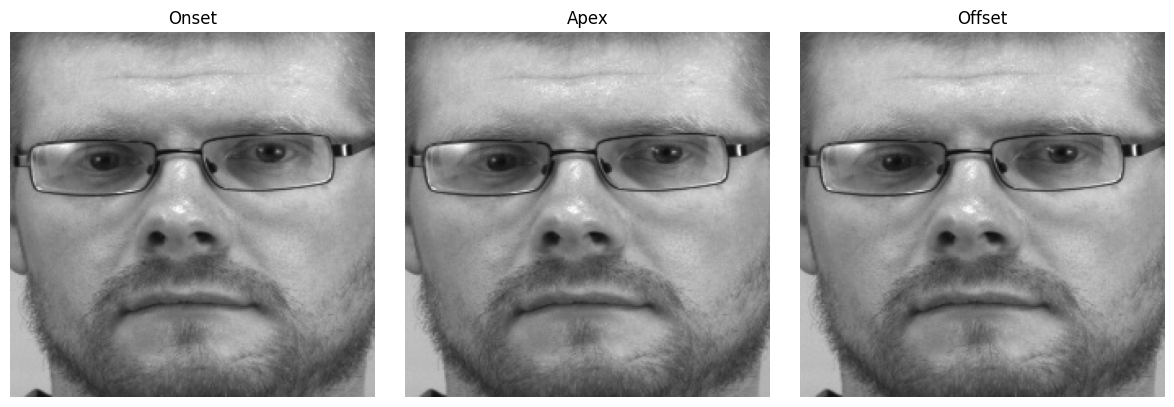

In [13]:
mostrar_secuencia_samm(
    base_dir="../datasets/SAMM2/SAMM_Normalized_TM",
    subject_id=subject_id,
    clip_name=clip_name,
    onset=onset,
    apex=apex,
    offset=offset
)

In [15]:
from notebook_utils import generar_gif_microexpresion
generar_gif_microexpresion(
    base_dir="../datasets/SAMM2/SAMM_Normalized_TM",
    subject_id="021",
    clip_name="021_7_1",
    onset=onset,
    apex=apex,
    offset=offset,
    output_path="021_7_1.gif",
    fps=1.5
)

✅ GIF guardado en: 021_7_1.gif


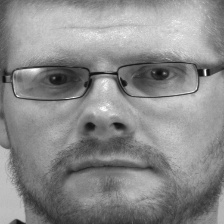

In [16]:
from IPython.display import Image as IPyImage, display

# Mostrar el GIF recién generado
display(IPyImage(filename="021_7_1.gif"))

### Cálculo del Optical Flow entre Onset y Apex

Una vez identificados los frames clave —**onset** (inicio del movimiento) y **apex** (pico de la microexpresión)—, podemos calcular el *optical flow* que representa el cambio facial entre esos dos momentos.

Este flujo óptico resume cómo se han desplazado los píxeles entre el estado neutro y el momento de máxima expresión, y nos permite **codificar ese movimiento en una imagen** que servirá como entrada al modelo.

#### ¿Por qué solo entre Onset y Apex?

- La **microexpresión** completa puede durar apenas unos pocos frames.
- El **cambio más informativo** ocurre entre el inicio y el pico, donde se condensa la emoción.
- Usar todo el clip puede introducir ruido y redundancia.


Este enfoque ha sido validado en trabajos como:
  - [Allaert et al., 2017](https://doi.org/10.3389/fpsyg.2017.00748): *“Consistent Optical Flow Maps for Micro-Expression Recognition”*

### Pipeline

1. Tomamos los recortes faciales **ya alineados** mediante *template matching*.
2. Seleccionamos las imágenes correspondientes a los frames de **onset** y **apex**.
3. Aplicamos nuestro método de cálculo de *optical flow denso* entre ambas.
4. Codificamos el resultado como una imagen RGB de resolución **28×28**, donde:
   - **Color** = dirección del movimiento
   - **Brillo** = magnitud del movimiento
5. Esa imagen se almacena y se usará como entrada del modelo.


In [17]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

def demo_flow(csv, norm_dir, subj, clip):
    from preprocess_optical_flows import SAMMFlowProcessor
    from notebook_utils import obtener_marcas_samm
    import cv2, matplotlib.pyplot as plt, os, glob

    # 1) Obtiene onset/apex
    o,a,_ = obtener_marcas_samm(csv, subj, clip)
    base = os.path.join(norm_dir, subj, clip)

    # 2) Busca robustamente los paths de onset y apex
    def find_img(frame):
        for z in (5,4):
            pattern = os.path.join(base, f"{subj}_{str(frame).zfill(z)}.jpg")
            matches = glob.glob(pattern)
            if matches:
                return matches[0]
        raise FileNotFoundError(f"No encontré imagen para {subj}/{clip}/{frame}")

    f1 = find_img(o)
    f2 = find_img(a)

    # 3) Genera flow a disco y lo lee
    SAMMFlowProcessor(csv, norm_dir, ".", (28,28))._generate_flow(f1, f2, "flow.png")
    flow = cv2.cvtColor(cv2.imread("flow.png"), cv2.COLOR_BGR2RGB)

    # 4) Carga onset/apex y muestra las 3 columnas
    imgs = [f1, f2, "flow.png"]
    titles = ["Onset", "Apex", "Flow 28×28"]
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    for ax, src, t in zip(axs, imgs, titles):
        img = cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB)
        ax.imshow(img); ax.set_title(t); ax.axis("off")
    plt.tight_layout(); plt.show()

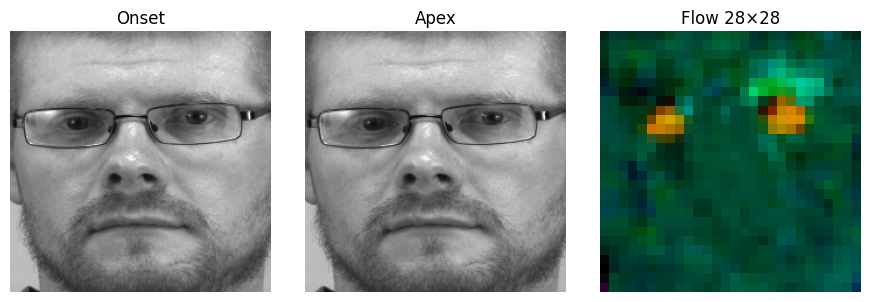

In [19]:
demo_flow(
    csv="../samm.csv",
    norm_dir="../datasets/SAMM2/SAMM_Normalized_TM",
    subj="021",
    clip="021_7_1"
)

En el mapa de Optical Flow de 28×28, el **color** codifica la **dirección** del movimiento y el **brillo** (valor) refleja la **magnitud** del desplazamiento:
- La **tonalidad** (H) proviene del ángulo del vector de flujo:  
    - Un **verde** suave (H≈60°) en el fondo indica direcciones con movimientos casi nulos.  
    - Un **amarillo** brillante (H≈30°) señala desplazamientos más fuertes en esa dirección.  
    - Si aparecieran azules, rojos u otros tonos, indicarían diferentes ángulos de movimiento.
- La **intensidad/luminosidad** (V) varía de oscuro a claro según la **magnitud** del cambio:  
    - Más claro = mayor desplazamiento.

> De este modo la imagen resultante no solo resalta **dónde** ocurre el movimiento (píxeles amarillos versus verdes), sino también **hacia dónde** se desplazan esos píxeles, ofreciendo una descripción completa de la dinámica facial entre el *onset* y el *apex*.

### Uso del Optical Flow como Entrada al Modelo

Gracias a esta codificación HSV→RGB de 28×28, disponemos de una **representación vectorial del movimiento facial** que:

- Captura **dirección** y **magnitud** de los desplazamientos entre *onset* y *apex*.  
- Resume la dinámica de la microexpresión en **solo 2 canales** (ángulo y magnitud), reduciendo la dimensionalidad frente a las imágenes completas.  
- Elimina gran parte del **ruido estático** (textura de piel, iluminación, fondos), enfocándose únicamente en la **variación del movimiento**.

Estas imágenes de flujo óptico se convierten en **inputs ideales** para redes ligeras de convolución porque:

1. **Vectorean la información** de cambio facial, en lugar de procesar píxeles estáticos irrelevantes.  
2. Su tamaño fijo (28×28) y bajo número de canales permite entrenar con **datasets pequeños** sin sobreajustar.  
3. Al reducir el ruido y la complejidad espacial, mejoramos la **robustez** y **eficiencia** del modelo, enfocándolo en las verdaderas microexpresiones.

Por tanto, en lugar de entrenar directamente con secuencias de imágenes completas—que contendrían demasiados datos irrelevantes y ruido—utilizamos estos **mapas de movimiento** para maximizar señal, minimizar ruido y optimizar el rendimiento en un escenario de datos limitados.  

## Generación masiva de mapas de Optical Flow

Con los rostros ya normalizados en `datasets/SAMM_Normalized_TM`, podemos procesar **solo** los Optical Flows para todo el dataset:

In [20]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))


from preprocess_optical_flows import SAMMFlowProcessor

# Parámetros
csv_path    = "../samm.csv"
input_base  = "../datasets/SAMM2/SAMM_Normalized_TM"
output_base = "../datasets/SAMM_FLOWS"

# Crear e invocar el procesador que recorre el CSV y genera un flujo por clip
processor = SAMMFlowProcessor(
    csv_path=csv_path,
    input_base=input_base,
    output_base=output_base,
    output_size=(28, 28)
)
processor.process()

Generando SAMM flows:  92%|█████████▏| 147/159 [00:00<00:00, 156.12it/s]

⚠️ No se encontraron imágenes para 028/028_4_1: onset=1071, apex=1143
⚠️ No se encontraron imágenes para 032/032_3_1: onset=4896, apex=1930


Generando SAMM flows: 100%|██████████| 159/159 [00:01<00:00, 154.85it/s]


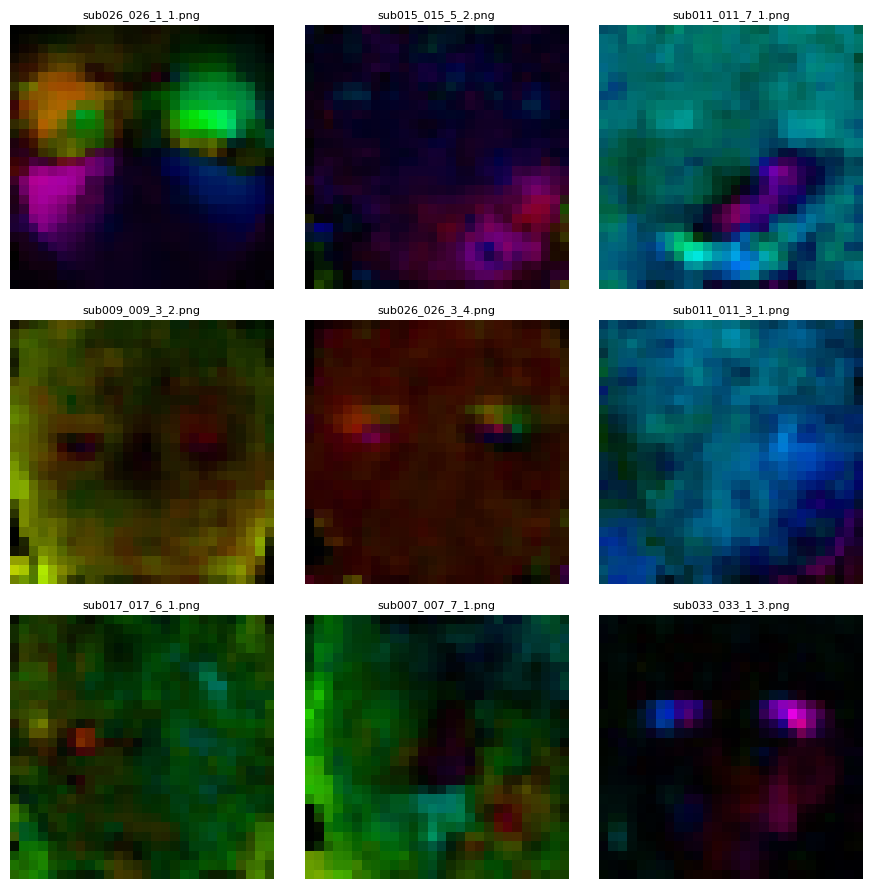

In [21]:
import random 
import cv2

def plot_3x3_flows(flow_dir, seed=42):

    files = [f for f in os.listdir(flow_dir) if f.lower().endswith('.png')]
    random.seed(seed)
    sample = random.sample(files, min(9, len(files)))

    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for ax, fn in zip(axs.flat, sample):
        img = cv2.imread(os.path.join(flow_dir, fn))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(fn, fontsize=8)
        ax.axis('off')

    # apagar ejes sobrantes si hay menos de 9
    for ax in axs.flat[len(sample):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_3x3_flows("../datasets/SAMM_FLOWS", seed=123)

La grilla 3×3 de mapas de flujo óptico muestra cómo, para diferentes sujetos y clips, nuestras representaciones de 28×28 capturan de forma clara y consistente las microvariaciones entre onset y apex.  
- Vemos variaciones en dirección y magnitud del movimiento facial (tonos y brillo), que corresponden a contracciones musculares sutiles en distintas áreas (párpados, comisuras labiales, cejas).  
- A pesar de la diversidad de rostros y expresiones, todos los flujos mantienen un fondo homogéneo (movimiento casi nulo) y resaltan solo las regiones realmente dinámicas.  
- Esta consistencia valida la efectividad de nuestro preprocesamiento (alineamiento + flujo denso) para aislar el cambio expresivo y descartar el ruido estático.

Con estos mapas vectoriales compactos, disponemos de inputs robustos y de baja dimensión, listos para entrenar un modelo que aprenda exclusivamente de la dinámica facial relevante.  